# Quantile Investigation with Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from functools import partial

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = ['../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [4]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [5]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [6]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [7]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [8]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [9]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


In [10]:
# Fill all missing values with the mean
for df in test_dfs + train_dfs:
    for column in df.columns:
        number_null = np.sum(df[column].isnull())
        column_length = len(df[column])
        print('{} percent null: {:.1f}%'.format(
            column, (number_null / column_length) * 100))
        if number_null > 0:
            print("Filling {} with mean: {}\n".format(column, df[column].mean()))
            df[column] = df[column].fillna(df[column].mean()) 

Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 3.2%
Filling Turbidity (NTU) with mean: 64.9625066543

## Quantiles

In [11]:
# Create Quantiles for min, mean, max
percentiles = [0.0, 1.0, 0.5]

In [12]:
test = train_dfs[0].copy()
test.quantile(percentiles)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0.0,5.63,3.0,-153.7,7.93,0.66,62.8,5.17,0.0
1.0,28.57,2164.0,-76.5,9.23,636.70,209.7,16.17,16.1
0.5,20.32,1939.0,-115.7,8.65,42.14,83.2,8.08,0.9


In [13]:
type(test[[target_column]].quantile(0.95))

pandas.core.series.Series

In [14]:
test.drop(columns=target_column).quantile(percentiles, numeric_only=False).add_suffix('_test')

,Temp C_test,Sp Cond (uS/cm)_test,pH (mV)_test,pH_test,Turbidity (NTU)_test,ODOSat%_test,ODO (mg/L)_test,datetime_test
0.0,5.63,3.0,-153.7,7.93,0.66,62.8,5.17,2017-05-05 00:00:00
1.0,28.57,2164.0,-76.5,9.23,636.70,209.7,16.17,2017-11-18 08:30:00
0.5,20.32,1939.0,-115.7,8.65,42.14,83.2,8.08,2017-08-11 16:15:00


In [15]:
sorted(percentiles)
print(percentiles)

[0.0, 1.0, 0.5]


In [16]:
df = test.drop(columns=target_column).quantile(percentiles, numeric_only=False)
df.head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),datetime
0.0,5.63,3.0,-153.7,7.93,0.66,62.8,5.17,2017-05-05 00:00:00
1.0,28.57,2164.0,-76.5,9.23,636.70,209.7,16.17,2017-11-18 08:30:00
0.5,20.32,1939.0,-115.7,8.65,42.14,83.2,8.08,2017-08-11 16:15:00


In [17]:
df['pH'][0.0]

7.93

In [18]:
e = pd.DataFrame()
for col in df.columns:
    for p in percentiles:
        new_column = col + "_percentile_{}".format(p)
        e[new_column] = [df[col][p]]
e.head()

,Temp C_percentile_0.0,Temp C_percentile_1.0,Temp C_percentile_0.5,Sp Cond (uS/cm)_percentile_0.0,Sp Cond (uS/cm)_percentile_1.0,Sp Cond (uS/cm)_percentile_0.5,pH (mV)_percentile_0.0,pH (mV)_percentile_1.0,pH (mV)_percentile_0.5,pH_percentile_0.0,...,Turbidity (NTU)_percentile_0.5,ODOSat%_percentile_0.0,ODOSat%_percentile_1.0,ODOSat%_percentile_0.5,ODO (mg/L)_percentile_0.0,ODO (mg/L)_percentile_1.0,ODO (mg/L)_percentile_0.5,datetime_percentile_0.0,datetime_percentile_1.0,datetime_percentile_0.5
0,5.63,28.57,20.32,3.0,2164.0,1939.0,-153.7,-76.5,-115.7,7.93,...,42.14,62.8,209.7,83.2,5.17,16.17,8.08,2017-05-05,2017-11-18 08:30:00,2017-08-11 16:15:00


In [19]:
percentiles = [0.0, 1.0, 0.5]
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = hf.windowize(
        train_dfs[i], 'datetime', target_column, feature_percentiles=percentiles)
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = hf.windowize(
        test_dfs[i], 'datetime', target_column, feature_percentiles=percentiles)
    print()

Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 1
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...



In [20]:
train_dfs[0].head()

,BGA-Phycocyanin RFU,ODO (mg/L)_0.0,ODO (mg/L)_0.5,ODO (mg/L)_1.0,ODOSat%_0.0,ODOSat%_0.5,ODOSat%_1.0,Sp Cond (uS/cm)_0.0,Sp Cond (uS/cm)_0.5,Sp Cond (uS/cm)_1.0,...,datetime_0.0,datetime_0.5,datetime_1.0,pH (mV)_0.0,pH (mV)_0.5,pH (mV)_1.0,pH_0.0,pH_0.5,pH_1.0,datetime
datetimeIndex,,,,,,,,,,,,,,,,,,,,,
2017-06-02 00:00:00,0.4,7.26,8.02,9.67,76.2,83.0,98.5,1327.0,1846.0,2033.0,...,2017-05-05 00:00:00,2017-05-19 00:00:00,2017-06-02 00:00:00,-110.5,-103.3,-98.9,8.33,8.42,8.52,2017-06-02 00:00:00
2017-06-02 14:00:00,0.3,7.26,8.00,9.67,76.2,82.8,98.5,1327.0,1843.0,2033.0,...,2017-05-05 14:00:00,2017-05-19 14:00:00,2017-06-02 14:00:00,-110.5,-103.5,-98.9,8.33,8.42,8.52,2017-06-02 14:00:00
2017-06-03 04:00:00,0.3,7.23,7.95,8.97,76.2,82.8,98.5,1327.0,1839.0,2033.0,...,2017-05-06 04:00:00,2017-05-20 04:00:00,2017-06-03 04:00:00,-110.5,-103.6,-98.9,8.33,8.42,8.52,2017-06-03 04:00:00
2017-06-03 18:00:00,0.2,7.09,7.92,8.97,76.2,82.7,98.5,1327.0,1837.0,2033.0,...,2017-05-06 18:00:00,2017-05-20 18:00:00,2017-06-03 18:00:00,-110.5,-103.8,-98.9,8.33,8.42,8.52,2017-06-03 18:00:00
2017-06-04 08:00:00,0.3,7.09,7.90,8.97,76.2,82.7,98.5,1327.0,1835.0,2033.0,...,2017-05-07 08:00:00,2017-05-21 08:00:00,2017-06-04 08:00:00,-110.5,-103.9,-98.9,8.33,8.42,8.52,2017-06-04 08:00:00


## Logistic Regression Model

In [21]:
# combine the sets
train = train_dfs[0].append(train_dfs[1])
test = test_dfs[0].append(test_dfs[1])

# update the feature column names.
to_drop = [target_column, 'datetime']
to_drop += ['datetime_{}'.format(p) for p in percentiles]
print(train.columns)
print("to drop", to_drop)
x_columns = train.drop(columns=to_drop).columns.values
print("new x:", x_columns)


# add the target
lrf.add_target_column([train, test], 
                      threshold=RFU_THRESHOLD)

Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)_0.0', 'ODO (mg/L)_0.5',
       'ODO (mg/L)_1.0', 'ODOSat%_0.0', 'ODOSat%_0.5', 'ODOSat%_1.0',
       'Sp Cond (uS/cm)_0.0', 'Sp Cond (uS/cm)_0.5', 'Sp Cond (uS/cm)_1.0',
       'Temp C_0.0', 'Temp C_0.5', 'Temp C_1.0', 'Turbidity (NTU)_0.0',
       'Turbidity (NTU)_0.5', 'Turbidity (NTU)_1.0', 'datetime_0.0',
       'datetime_0.5', 'datetime_1.0', 'pH (mV)_0.0', 'pH (mV)_0.5',
       'pH (mV)_1.0', 'pH_0.0', 'pH_0.5', 'pH_1.0', 'datetime'],
      dtype='object')
to drop ['BGA-Phycocyanin RFU', 'datetime', 'datetime_0.0', 'datetime_1.0', 'datetime_0.5']
new x: ['ODO (mg/L)_0.0' 'ODO (mg/L)_0.5' 'ODO (mg/L)_1.0' 'ODOSat%_0.0'
 'ODOSat%_0.5' 'ODOSat%_1.0' 'Sp Cond (uS/cm)_0.0' 'Sp Cond (uS/cm)_0.5'
 'Sp Cond (uS/cm)_1.0' 'Temp C_0.0' 'Temp C_0.5' 'Temp C_1.0'
 'Turbidity (NTU)_0.0' 'Turbidity (NTU)_0.5' 'Turbidity (NTU)_1.0'
 'pH (mV)_0.0' 'pH (mV)_0.5' 'pH (mV)_1.0' 'pH_0.0' 'pH_0.5' 'pH_1.0']


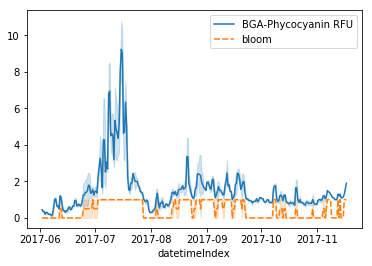

In [22]:
sns.lineplot(data=train[[target_column, 'bloom']], hue='bloom')

In [23]:
# The null model's performance
max_iter = 25000
loss = "log"
print(x_columns)
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train, test, x_columns, 'bloom', True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train.columns)

['ODO (mg/L)_0.0' 'ODO (mg/L)_0.5' 'ODO (mg/L)_1.0' 'ODOSat%_0.0'
 'ODOSat%_0.5' 'ODOSat%_1.0' 'Sp Cond (uS/cm)_0.0' 'Sp Cond (uS/cm)_0.5'
 'Sp Cond (uS/cm)_1.0' 'Temp C_0.0' 'Temp C_0.5' 'Temp C_1.0'
 'Turbidity (NTU)_0.0' 'Turbidity (NTU)_0.5' 'Turbidity (NTU)_1.0'
 'pH (mV)_0.0' 'pH (mV)_0.5' 'pH (mV)_1.0' 'pH_0.0' 'pH_0.5' 'pH_1.0']
Accuracy 0.3695652173913043
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[221   0]
 [377   0]]
columns: Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)_0.0', 'ODO (mg/L)_0.5',
       'ODO (mg/L)_1.0', 'ODOSat%_0.0', 'ODOSat%_0.5', 'ODOSat%_1.0',
       'Sp Cond (uS/cm)_0.0', 'Sp Cond (uS/cm)_0.5', 'Sp Cond (uS/cm)_1.0',
       'Temp C_0.0', 'Temp C_0.5', 'Temp C_1.0', 'Turbidity (NTU)_0.0',
       'Turbidity (NTU)_0.5', 'Turbidity (NTU)_1.0', 'datetime_0.0',
       'datetime_0.5', 'datetime_1.0', 'pH (mV)_0.0', 'pH (mV)_0.5',
       'pH (mV)_1.0', 'pH_0.0', 'pH_0.5', 'pH_1.0', 'datetime', 'bloom'],
      dtype='object')


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')

Training model with: ODO (mg/L)_0.0
Accuracy 0.6404682274247492
Recall: 0.4588859416445623
Precision 0.9402173913043478
Confusion Matrix:
 [[210  11]
 [204 173]]

Training model with: ODO (mg/L)_0.5
Accuracy 0.5016722408026756
Recall: 0.2625994694960212
Precision 0.8319327731092437
Confusion Matrix:
 [[201  20]
 [278  99]]

Training model with: ODO (mg/L)_1.0
Accuracy 0.6705685618729097
Recall: 0.4960212201591512
Precision 0.9639175257731959
Confusion Matrix:
 [[214   7]
 [190 187]]

Training model with: ODOSat%_0.0
Accuracy 0.5434782608695652
Recall: 0.3050397877984085
Precision 0.9126984126984127
Confusion Matrix:
 [[210  11]
 [262 115]]

Training model with: ODOSat%_0.5
Accuracy 0.6722408026755853
Recall: 0.596816976127321
Precision 0.8364312267657993
Confusion Matrix:
 [[177  44]
 [152 225]]

Training model with: ODOSat%_1.0
Accuracy 0.6705685618729097
Recall: 0.4960212201591512
Precision 0.9639175257731959
Confusion Matrix:
 [[214   7]
 [190 187]]

Training model with: Sp Cond (uS

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3695652173913043
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[221   0]
 [377   0]]

Training model with: Sp Cond (uS/cm)_0.5
Accuracy 0.33277591973244147
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[199  22]
 [377   0]]

Training model with: Sp Cond (uS/cm)_1.0
Accuracy 0.23411371237458195
Recall: 0.11140583554376658
Precision 0.2545454545454545
Confusion Matrix:
 [[ 98 123]
 [335  42]]

Training model with: Temp C_0.0
Accuracy 0.7725752508361204
Recall: 0.7055702917771883
Precision 0.9140893470790378
Confusion Matrix:
 [[196  25]
 [111 266]]

Training model with: Temp C_0.5
Accuracy 0.7240802675585284
Recall: 0.5702917771883289
Precision 0.9862385321100917
Confusion Matrix:
 [[218   3]
 [162 215]]

Training model with: Temp C_1.0
Accuracy 0.6672240802675585
Recall: 0.4854111405835544
Precision 0.973404255319149
Confusion Matrix:
 [[216   5]
 [194 183]]

Training model with: Turbidity (NTU)_0.0
Accuracy 0.7040133779264214
Recall: 0.5729442970822282
Precision 0.9310344827

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3695652173913043
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[221   0]
 [377   0]]

Training model with: pH (mV)_0.0
Accuracy 0.7190635451505016
Recall: 0.9204244031830239
Precision 0.7154639175257732
Confusion Matrix:
 [[ 83 138]
 [ 30 347]]

Training model with: pH (mV)_0.5
Accuracy 0.6304347826086957
Recall: 1.0
Precision 0.6304347826086957
Confusion Matrix:
 [[  0 221]
 [  0 377]]

Training model with: pH (mV)_1.0
Accuracy 0.596989966555184
Recall: 0.7400530503978779
Precision 0.6611374407582938
Confusion Matrix:
 [[ 78 143]
 [ 98 279]]

Training model with: pH_0.0


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.3695652173913043
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[221   0]
 [377   0]]

Training model with: pH_0.5
Accuracy 0.6923076923076923
Recall: 0.7877984084880637
Precision 0.7406483790523691
Confusion Matrix:
 [[117 104]
 [ 80 297]]

Training model with: pH_1.0
Accuracy 0.754180602006689
Recall: 0.896551724137931
Precision 0.757847533632287
Confusion Matrix:
 [[113 108]
 [ 39 338]]

Temp C_0.0 metric value: 0.7725752508361204
pH_1.0 metric value: 0.754180602006689
Temp C_0.5 metric value: 0.7240802675585284
pH (mV)_0.0 metric value: 0.7190635451505016
Turbidity (NTU)_0.0 metric value: 0.7040133779264214
pH_0.5 metric value: 0.6923076923076923
ODOSat%_0.5 metric value: 0.6722408026755853
ODO (mg/L)_1.0 metric value: 0.6705685618729097
ODOSat%_1.0 metric value: 0.6705685618729097
Temp C_1.0 metric value: 0.6672240802675585
ODO (mg/L)_0.0 metric value: 0.6404682274247492
pH (mV)_0.5 metric value: 0.6304347826086957
pH (mV)_1.0 metric value: 0.596989966555184
ODOSat%_0.0 

In [25]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train, test, x_columns, 'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['Temp C_0.0', 'pH_1.0', 'Temp C_0.5', 'pH (mV)_0.0', 'Turbidity (NTU)_0.0', 'pH_0.5', 'ODOSat%_0.5', 'ODO (mg/L)_1.0', 'ODOSat%_1.0', 'Temp C_1.0', 'ODO (mg/L)_0.0', 'pH (mV)_0.5', 'pH (mV)_1.0', 'ODOSat%_0.0', 'ODO (mg/L)_0.5', 'Turbidity (NTU)_0.5', 'Sp Cond (uS/cm)_0.0', 'Turbidity (NTU)_1.0', 'pH_0.0', 'Sp Cond (uS/cm)_0.5', 'Sp Cond (uS/cm)_1.0']
adjusted sorted_columns: ['Temp C_0.0', 'pH_1.0', 'Temp C_0.5', 'pH (mV)_0.0', 'Turbidity (NTU)_0.0', 'pH_0.5', 'ODOSat%_0.5', 'ODO (mg/L)_1.0', 'ODOSat%_1.0', 'Temp C_1.0', 'ODO (mg/L)_0.0', 'pH (mV)_0.5', 'pH (mV)_1.0', 'ODOSat%_0.0', 'ODO (mg/L)_0.5', 'Turbidity (NTU)_0.5', 'Sp Cond (uS/cm)_0.0', 'Turbidity (NTU)_1.0', 'pH_0.0', 'Sp Cond (uS/cm)_0.5', 'Sp Cond (uS/cm)_1.0']
Training model with: ['Temp C_0.0']
Test model accuracy: 0.7725752508361204
Test model recall: 0.7055702917771883
Test model precision: 0.9140893470790378

Updating greedy model

Training model with: ['Temp C_0.0', 'pH_1.0']
Test mo

Model AUC: 0.8050


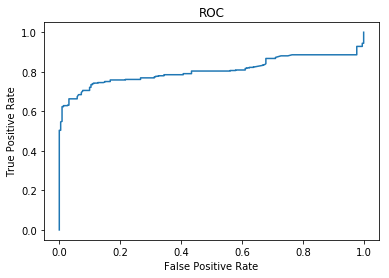

In [26]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test[['bloom']].values, predictions)

In [29]:
# cross Validate
new_x = ['Temp C_0.0', 'Sp Cond (uS/cm)_0.5', 'Sp Cond (uS/cm)_1.0']
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, test, train, new_x, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.629695885509839
Recall: 0.7398373983739838
Precision 0.56
Confusion Matrix:
 [[170 143]
 [ 64 182]]


## Random Forest Model

In [ ]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train, test, x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

In [ ]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test[['bloom']].values, predictions)